In [226]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Régression logistique : prédictions des risques cardio-vasculaires

## Sommaire

- Introduction et contexte du projet
- Pré-traitement des données
- Visualisation et analyse des données
- Régression logistique avec scikit-learn
- Régression logistique avec ma propre classe
- Évaluation des résultats avec des mesures de qualité
- Prédiction pour Arthur
- Conclusion

## Introduction et contexte du projet

Ce projet consiste au développement d'un outil permettant de poser un diagnostic de risque de maladies cardio-vasculaire. Nous allons mettre en place un algorithme de machine learning de classification binaire, notamment la régression logistique. Pour cela, des données patients nous sont fournies, contenant les caractéristiques suivantes :

- age : âge en nombre de jours (entier)
- height : hauteur en cm (entier)
- weight : poids en kg (entier)
- gender : genre, catégoriel (1 : féminin, 2 : masculin)
- ap_high : tension artérielle systolique (entier)
- ap_low : tension artérielle diastolique (entier)
- cholesterol : taux de cholestérol, catégorique (1 : normal, 2 : au-dessus de la normale, 3 : bien au-dessus de la normale)
- glucose : taux de glucose, catégorique (1 : normal, 2 : au-dessus de la normale, 3 : bien au-dessus de la normale)
- smoke : si patient fume ou non, catégorique (0 : non, 1 : oui)
- alcohol : si le patient boit de l'alcool ou non, catégorique (0 : non, 1 : oui)
- physical_activity : si le patient est actif ou non, catégorique (0 : non, 1 : oui)

et la caractéristique cible : 
- cardio_disease : si le patient a contracté la maladie ou non, catégorique (0 : non, 1 : oui)

## Pré-traitement des données

### Informations globales

In [227]:
df = pd.read_csv('./cardio_train.csv', sep=';')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [228]:
df.tail()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1
69999,99999,20540,1,170,72.0,120,80,2,1,0,0,1,0


In [229]:
df.shape

(70000, 13)

In [230]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


Nous avons uniquement des données numériques dans notre jeu de données. 

La colonne 'age' représente l'âge en jours. Nous allons la convertir en années pour une meilleure compréhension.

In [231]:
df['age'] = (df['age'] / 365).round().astype('int')

In [232]:
df.nunique()

id             70000
age               28
gender             2
height           109
weight           287
ap_hi            153
ap_lo            157
cholesterol        3
gluc               3
smoke              2
alco               2
active             2
cardio             2
dtype: int64

In [233]:
df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,53.338686,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,6.765294,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,30.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,58.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,65.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


En affichant les statistiques descriptives et les valeurs uniques, nous pouvons observer plusieurs aspects intéressants :

La caractéristique 'gender' comporte deux valeurs uniques (1 et 2) correspondant respectivement à féminin et masculin.

Les caractéristiques 'smoke', 'alco', 'active' et 'cardio' présentent deux valeurs uniques (0 et 1) représentant non et oui.

Les caractéristiques 'cholesterol' et 'gluc' affichent trois valeurs uniques (1, 2, 3), qui indiquent les niveaux de normalité du taux de cholestérol et de glucose.

Pour chacune de ces caractéristiques, les valeurs sont correctes et correspondent exactement à ce qui est attendu, sans présence de valeurs inappropriées.

Pour la caractéristique 'age', les données sont cohérentes, avec un âge minimum de 30 ans, un âge maximum de 65 ans, et une moyenne d'âge de 53 ans. L'âge minimum reste néanmoins loin de la moyenne.

Pour la taille (height), la valeur minimale de 55 cm pourrait laisser penser qu'il s'agit d'enfants, cependant, étant donné que l'âge minimal est de 30 ans, cette valeur est clairement aberrante. La taille moyenne est d'environ 164 cm, avec un écart-type de 8.2. 

Concernant le poids (weight), nous pouvons également observer des valeurs aberrantes, comme le poids minimum à 10 kg. Les valeurs sont assez dispersées autour de la moyenne avec un écart-type d'environ 14.

Enfin, pour les données sur les tensions artérielles systoliques et diastoliques (ap_hi, ap_lo), nous avons récupéré le tableau de la pression artérielle pour comparer ces valeurs avec nos résultats.

![](./img/image.png)

Dans notre jeu de données, nous constatons des valeurs extrêmes et aberrantes pour les deux types de tension artérielle :

- Pour la tension systolique (ap_hi), nous observons un minimum d'environ -150 et un maximum d'environ 16 000. Selon le tableau de référence, une tension inférieure à 90 est considérée comme basse, tandis qu'une tension supérieure à 180 est qualifiée de 'crise hypertensive'.
- En ce qui concerne la tension diastolique (ap_lo), la plage normale se situe généralement entre un peu moins de 60 et un peu plus de 120. Cependant, nos données présentent des valeurs extrêmes avec une tension minimale d'environ -70 et une tension maximale d'environ 11 000.

Ces statistiques montrent la présence de valeurs extrêmes et aberrantes, qui nécessitent une analyse plus approfondie pour garantir la fiabilité des données. 

### Données manquantes

In [234]:
df.isnull().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

Il n'y a pas de données manquantes.

In [235]:
df.duplicated().sum()  

0

### Données aberrantes

Lors de l'analyse des statistiques descriptives, plusieurs caractéristiques ont montré des valeurs extrêmes et aberrantes, notamment
- age
- height
- weight
- ap_hi
- ap_lo

Pour mieux comprendre la nature de ces valeurs aberrantes, nous allons utiliser des graphiques de type "Boîte à moustaches". Ces graphiques nous permettront de visualiser la distribution des données, y compris les valeurs extrêmes, afin d'identifier et d'analyser plus précisément les observations atypiques dans nos données.

Nous allons ensuite définir des seuils supérieurs et inférieurs afin de filtrer ces valeurs extrêmes du jeu de données.

Cette étape est essentielle pour nettoyer nos données et assurer la qualité de notre analyse statistique. En établissant des seuils, on s'assure de travailler avec des données plus fiables et représentatives de notre étude, ce qui est crucial dans le cadre de notre projet de détection des maladies cardiovasculaires avec l'algorithme de régression logistique. Cet algorithme est sensible aux données aberrantes, en les éliminant, nous optimisons les performances de notre algorithme et améliorons la fiabilité de nos résultats.


#### Colonne 'age'

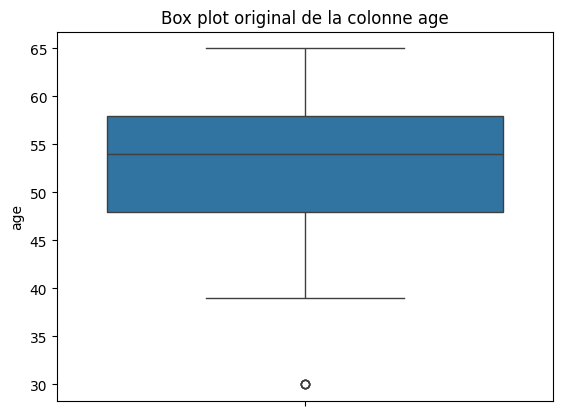

In [236]:
sns.boxplot(df['age'])
plt.title(f'Box plot original de la colonne age')
plt.show()

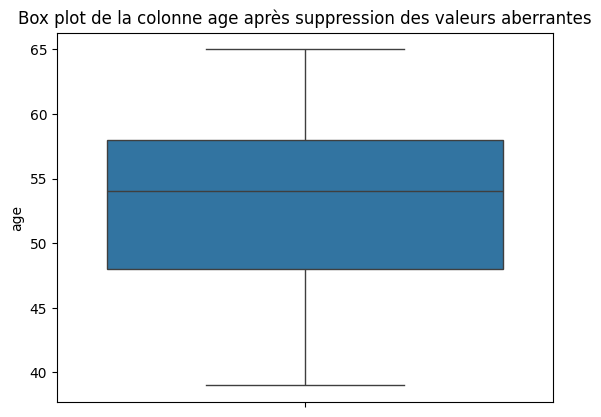

In [237]:
threshold_down = 35
df = df[(df['age'] > threshold_down)]

sns.boxplot(df['age'])
plt.title(f'Box plot de la colonne age après suppression des valeurs aberrantes')
plt.show()

#### Colonne 'height'

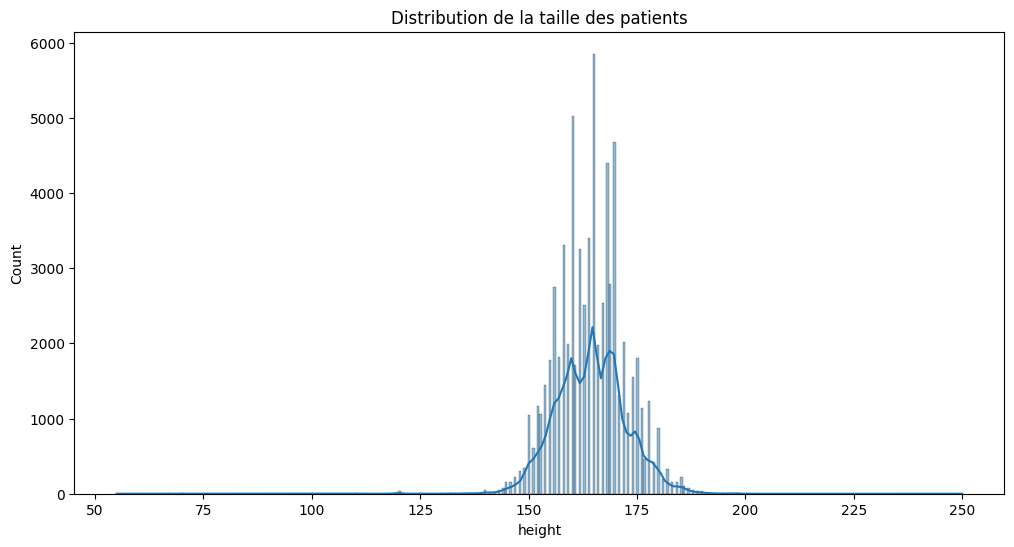

In [238]:
plt.figure(figsize=(12, 6))
sns.histplot(df['height'], kde=True)
plt.title('Distribution de la taille des patients')
plt.show()

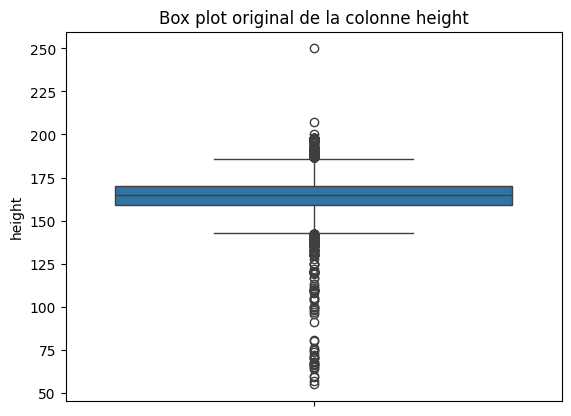

In [239]:
sns.boxplot(df['height'])
plt.title(f'Box plot original de la colonne height')
plt.show()

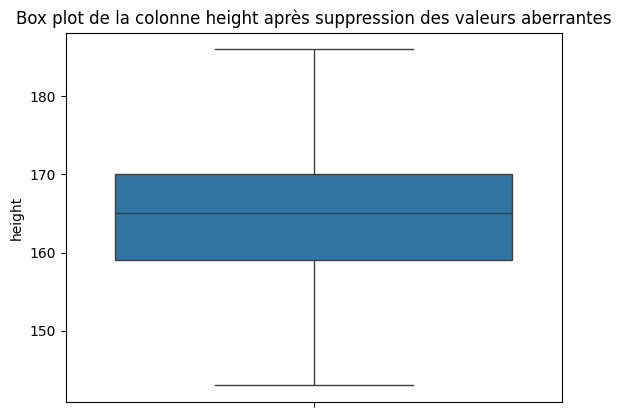

In [240]:
threshold_down = 142
threshold_up = 187
df = df[(df['height'] > threshold_down) & (df['height'] < threshold_up)]

sns.boxplot(df['height'])
plt.title(f'Box plot de la colonne height après suppression des valeurs aberrantes')
plt.show()

#### Colonne 'weight'

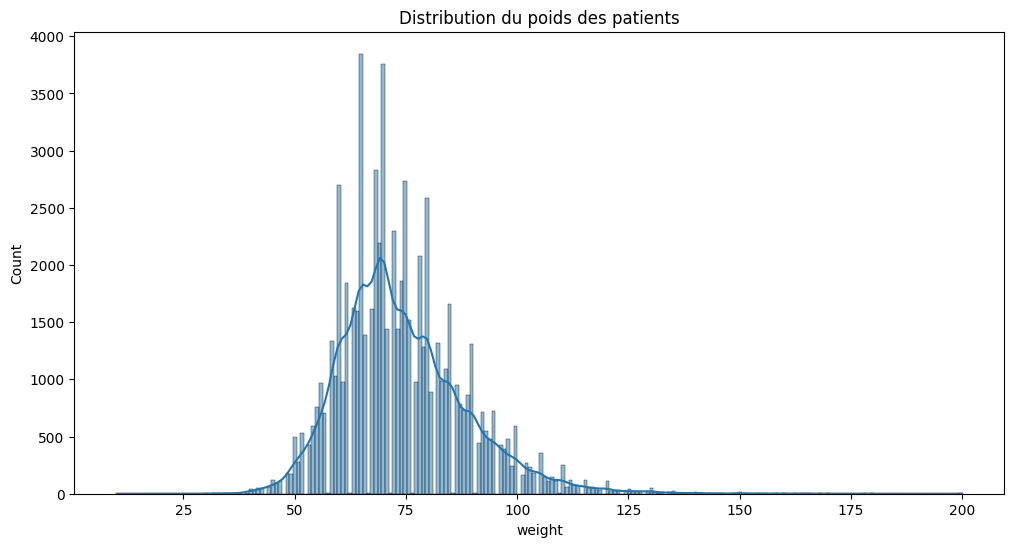

In [241]:
plt.figure(figsize=(12, 6))
sns.histplot(df['weight'], kde=True)
plt.title('Distribution du poids des patients')
plt.show()

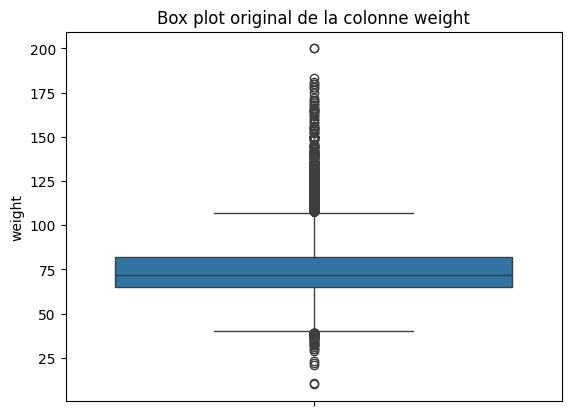

In [242]:
sns.boxplot(df['weight'])
plt.title(f'Box plot original de la colonne weight')
plt.show()

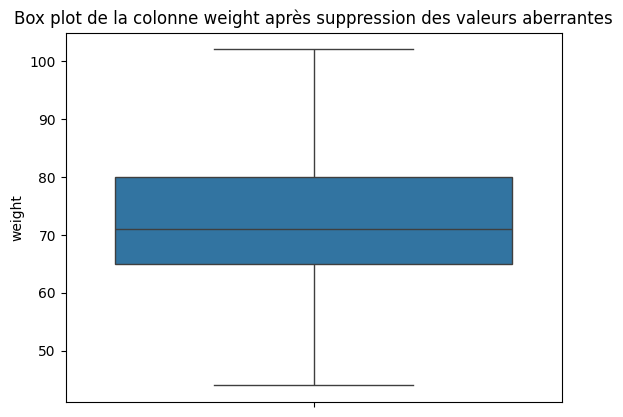

In [243]:
threshold_down = 43
threshold_up = 103
df = df[(df['weight'] > threshold_down) & (df['weight'] < threshold_up)]

sns.boxplot(df['weight'])
plt.title(f'Box plot de la colonne weight après suppression des valeurs aberrantes')
plt.show()

#### Colonne 'ap_hi'

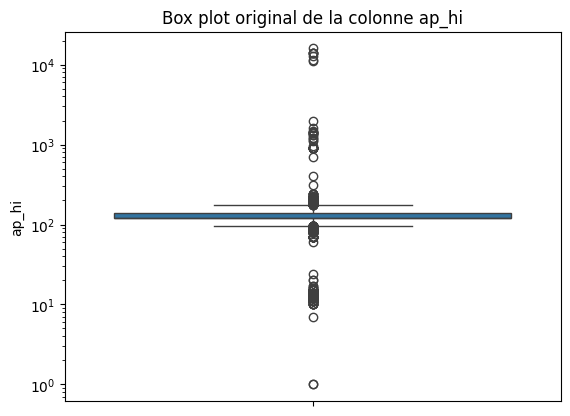

In [244]:
sns.boxplot(df['ap_hi'], log_scale=True)
plt.title(f'Box plot original de la colonne ap_hi')
plt.show()

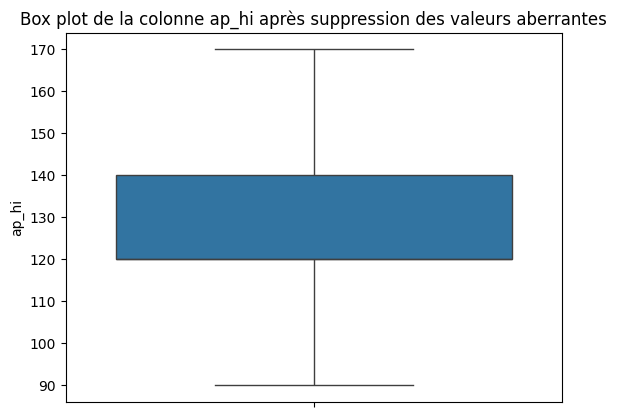

In [245]:
threshold_down = 85
threshold_up = 171
df = df[(df['ap_hi'] > threshold_down) & (df['ap_hi'] < threshold_up)]

sns.boxplot(df['ap_hi'])
plt.title(f'Box plot de la colonne ap_hi après suppression des valeurs aberrantes')
plt.show()

#### Colonne 'ap_lo'

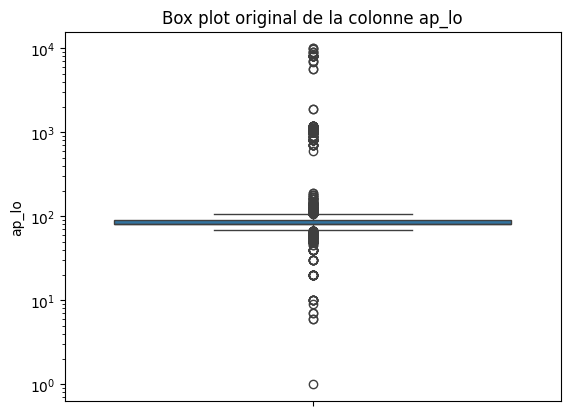

In [246]:
sns.boxplot(df['ap_lo'], log_scale=True)
plt.title(f'Box plot original de la colonne ap_lo')
plt.show()

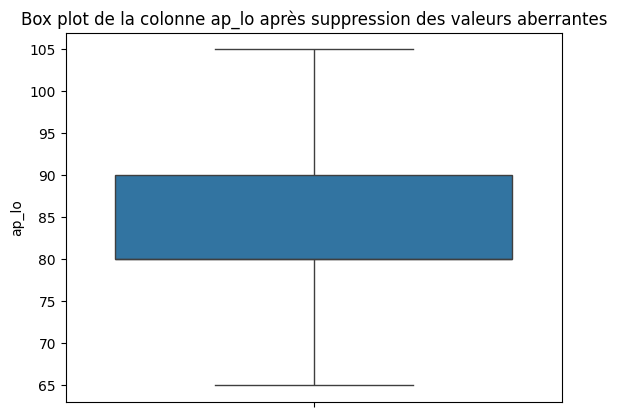

In [247]:
threshold_down = 64
threshold_up = 106
df = df[(df['ap_lo'] > threshold_down) & (df['ap_lo'] < threshold_up)]

sns.boxplot(df['ap_lo'])
plt.title(f'Box plot de la colonne ap_lo après suppression des valeurs aberrantes')
plt.show()

In [248]:
df.shape

(61428, 13)

#### Visualisation des données

##### Corrélations

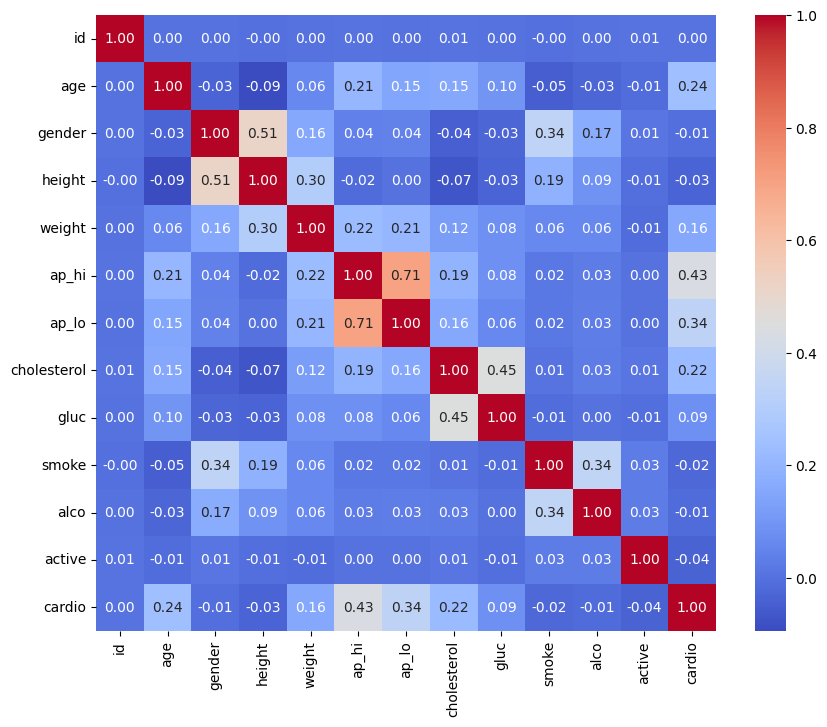

In [249]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

##### Répartition des classes

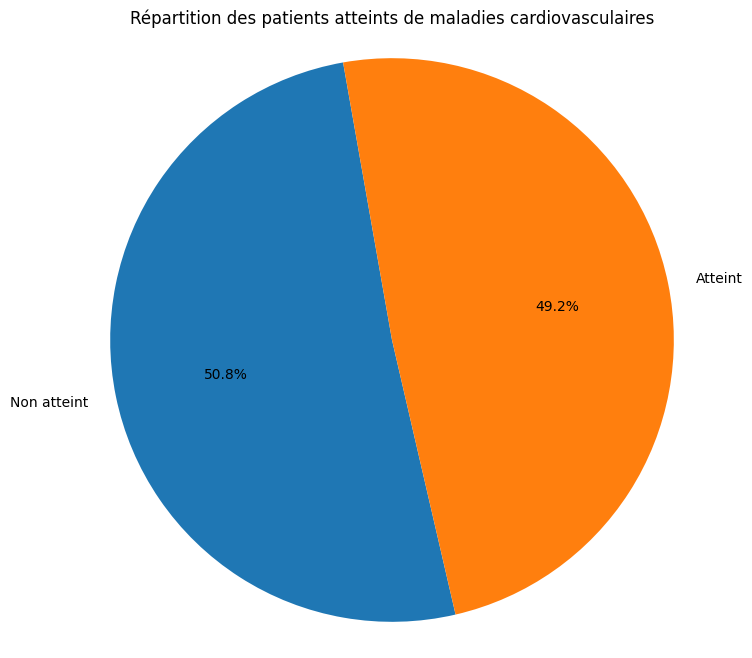

In [274]:
cardio_counts = df['cardio'].value_counts()

total_patients = cardio_counts.sum()
percentages = [count / total_patients * 100 for count in cardio_counts]

plt.figure(figsize=(8, 8))
plt.pie(percentages, labels=['Non atteint', 'Atteint'], autopct='%1.1f%%', startangle=100)
plt.title('Répartition des patients atteints de maladies cardiovasculaires')
plt.axis('equal')
plt.show()


##### Analyse univariée

Colonne 'age'

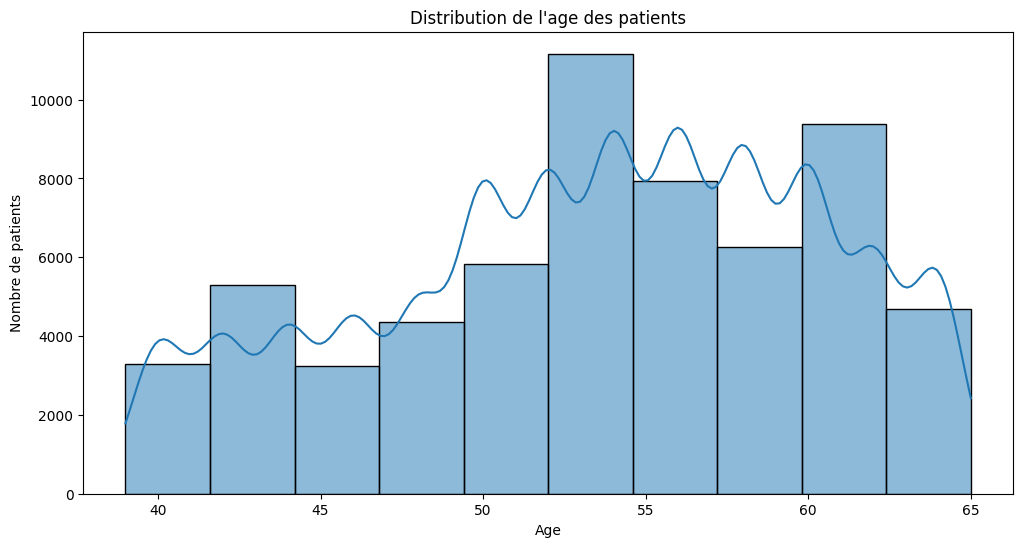

In [251]:
plt.figure(figsize=(12, 6))
sns.histplot(df['age'], bins=10, kde=True)
plt.title('Distribution de l\'age des patients')
plt.xlabel('Age')
plt.ylabel('Nombre de patients')
plt.show()

Colonne 'gender'

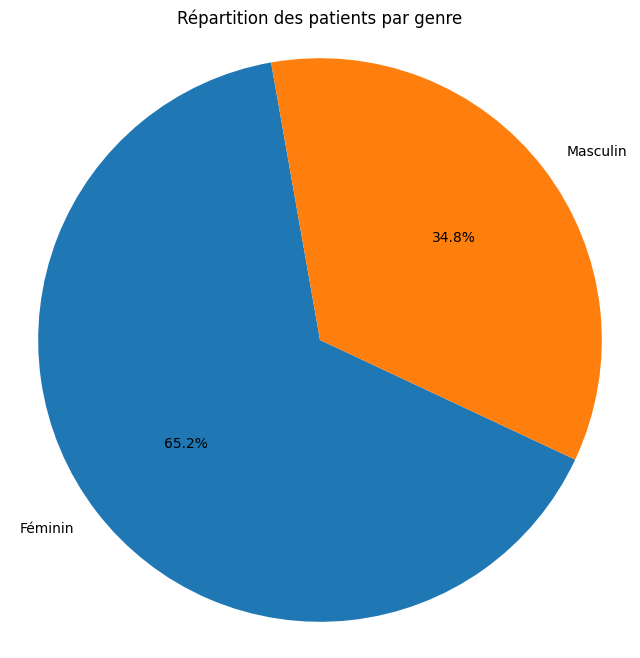

In [273]:
gender_counts = df['gender'].value_counts()

total_patients = gender_counts.sum()
percentages = [count / total_patients * 100 for count in gender_counts]

plt.figure(figsize=(8, 8))
plt.pie(percentages, labels=['Féminin', 'Masculin'], autopct='%1.1f%%', startangle=100)
plt.title('Répartition des patients par genre')
plt.axis('equal')
plt.show()

Colonne 'height'

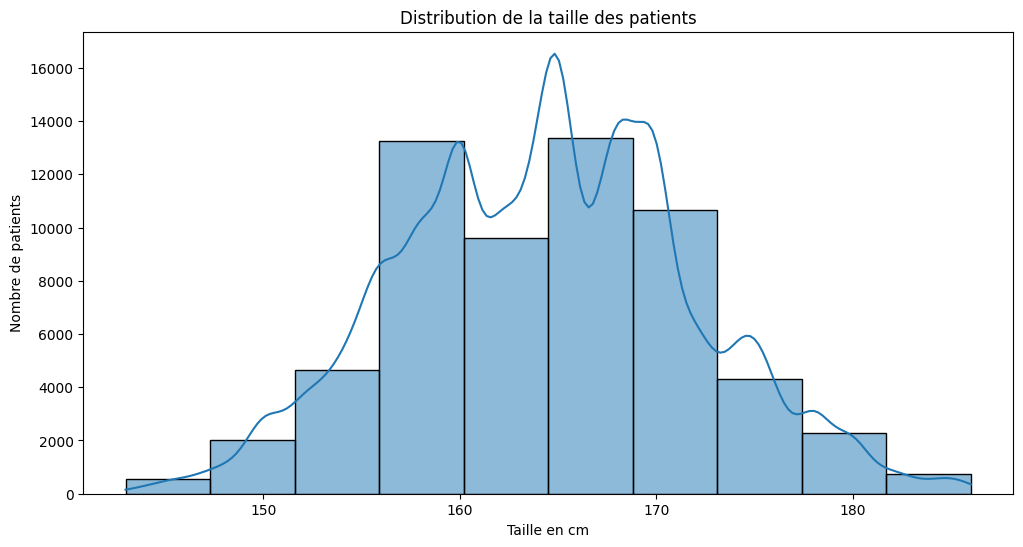

In [253]:
plt.figure(figsize=(12, 6))
sns.histplot(df['height'], bins=10, kde=True)
plt.title('Distribution de la taille des patients')
plt.xlabel('Taille en cm')
plt.ylabel('Nombre de patients')
plt.show()

Colonne 'weight'

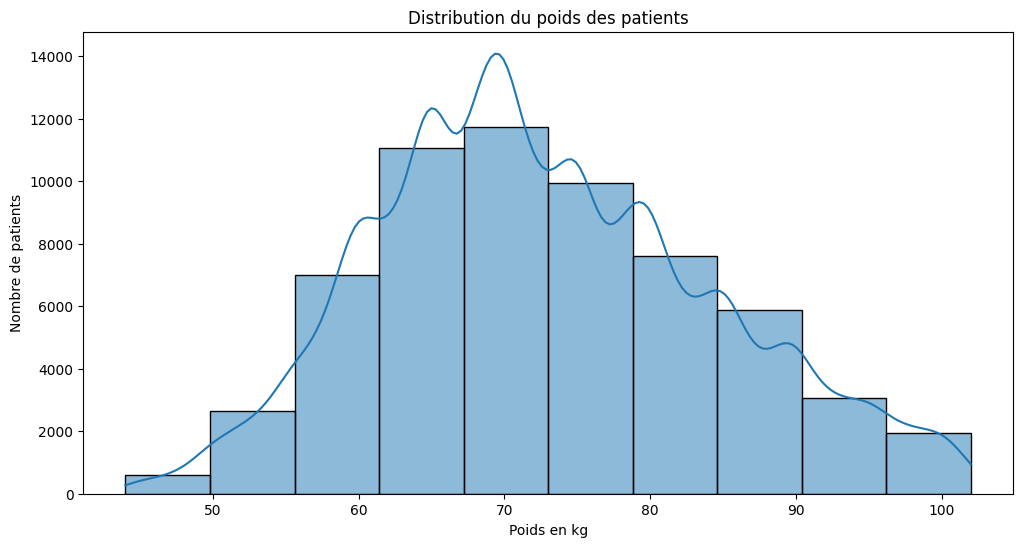

In [254]:
plt.figure(figsize=(12, 6))
sns.histplot(df['weight'], bins=10, kde=True)
plt.title('Distribution du poids des patients')
plt.xlabel('Poids en kg')
plt.ylabel('Nombre de patients')
plt.show()


Colonne 'ap_hi'

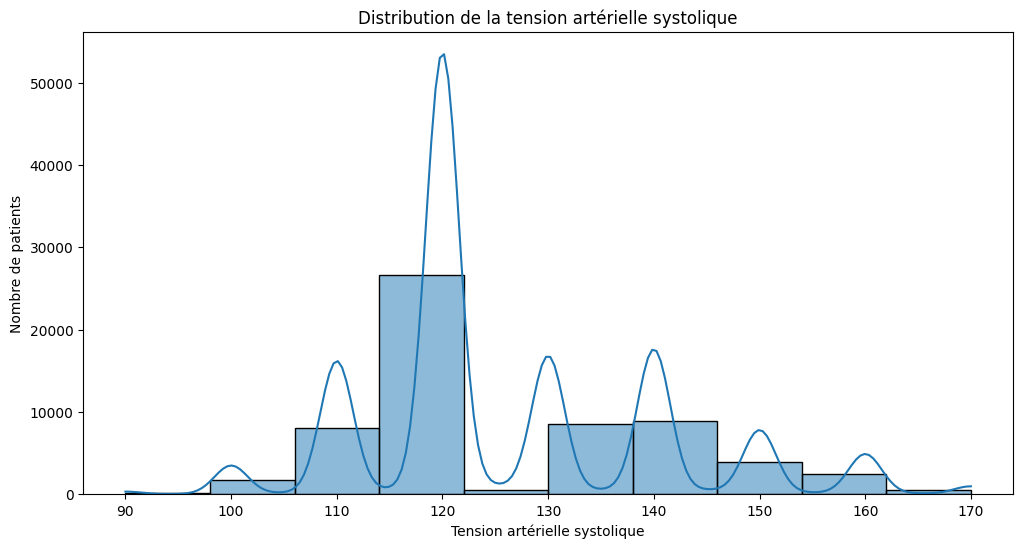

In [255]:
plt.figure(figsize=(12, 6))
sns.histplot(df['ap_hi'], bins=10, kde=True)
plt.title('Distribution de la tension artérielle systolique')
plt.xlabel('Tension artérielle systolique')
plt.ylabel('Nombre de patients')
plt.show()

Colonne 'ap_low'

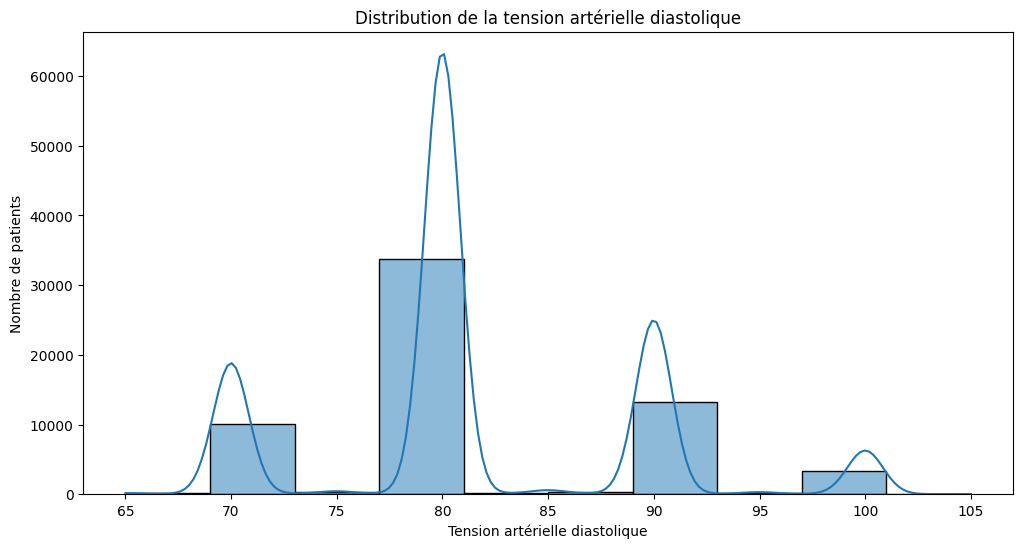

In [256]:
plt.figure(figsize=(12, 6))
sns.histplot(df['ap_lo'], bins=10, kde=True)
plt.title('Distribution de la tension artérielle diastolique')
plt.xlabel('Tension artérielle diastolique')
plt.ylabel('Nombre de patients')
plt.show()

Colonne 'cholesterol'

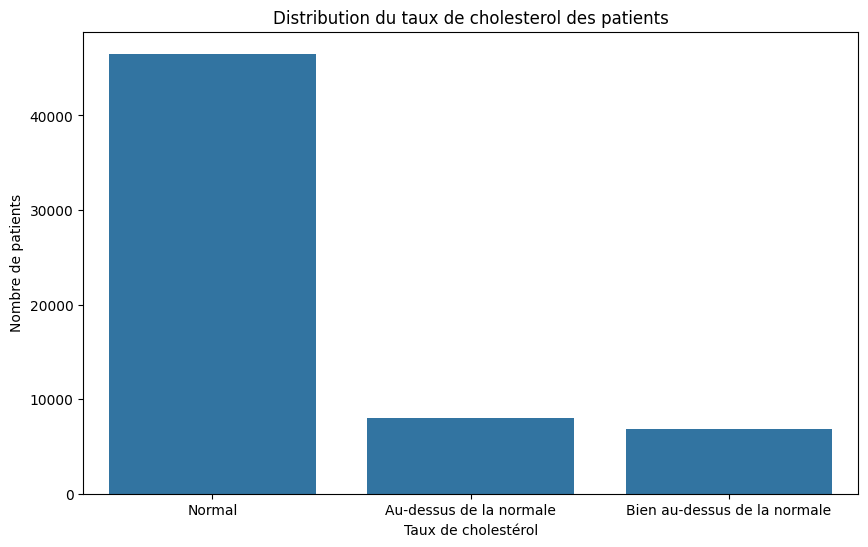

In [257]:
plt.figure(figsize=(10, 6))
sns.countplot(x='cholesterol', data=df)
plt.title('Distribution du taux de cholesterol des patients')
plt.xlabel('Taux de cholestérol')
plt.ylabel('Nombre de patients')
plt.xticks([0, 1, 2],  ['Normal', 'Au-dessus de la normale', 'Bien au-dessus de la normale'])
plt.show()

Colonne 'gluc'

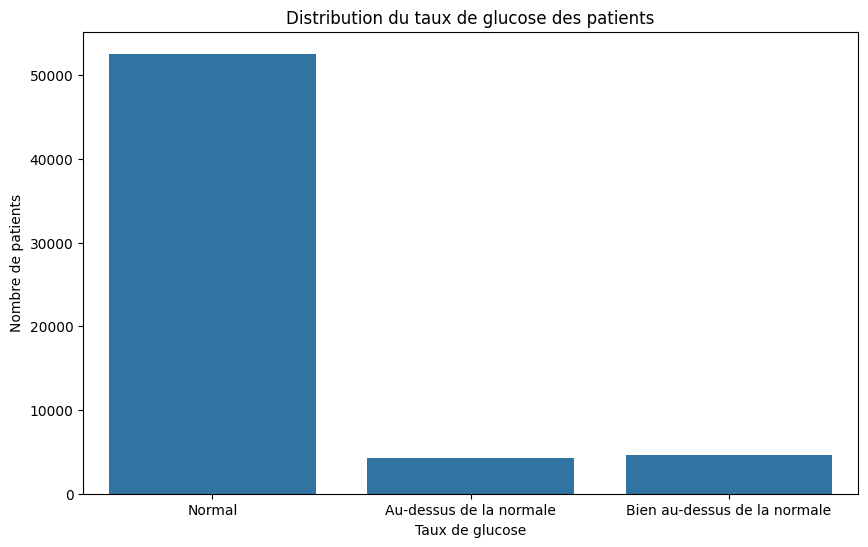

In [258]:
plt.figure(figsize=(10, 6))
sns.countplot(x='gluc', data=df)
plt.title('Distribution du taux de glucose des patients')
plt.xlabel('Taux de glucose')
plt.ylabel('Nombre de patients')
plt.xticks([0, 1, 2],  ['Normal', 'Au-dessus de la normale', 'Bien au-dessus de la normale'])
plt.show()

Colonne 'smoke'

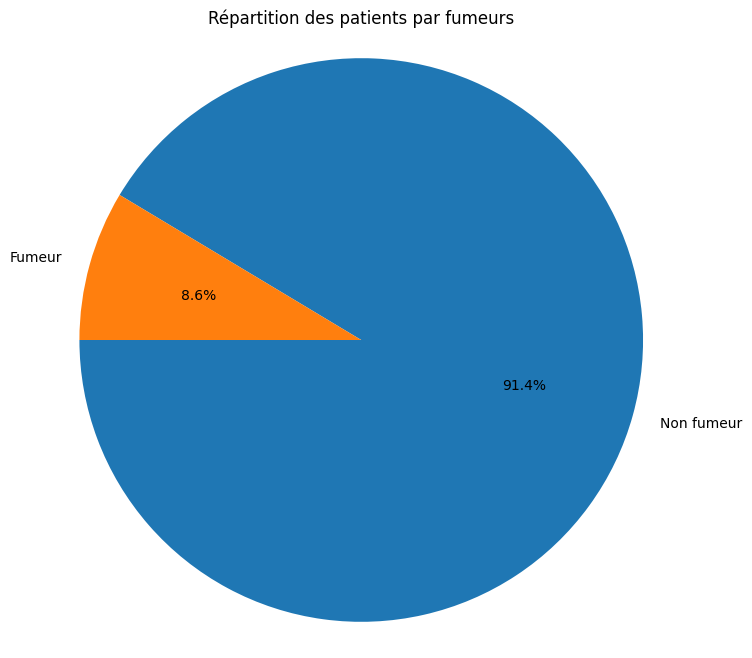

In [277]:
smoke_counts = df['smoke'].value_counts()

total_patients = smoke_counts.sum()
percentages = [count / total_patients * 100 for count in smoke_counts]

plt.figure(figsize=(8, 8))
plt.pie(percentages, labels=['Non fumeur', 'Fumeur'], autopct='%1.1f%%', startangle=180)
plt.title('Répartition des patients par fumeurs')
plt.axis('equal') 
plt.show()

Colonne 'alco'

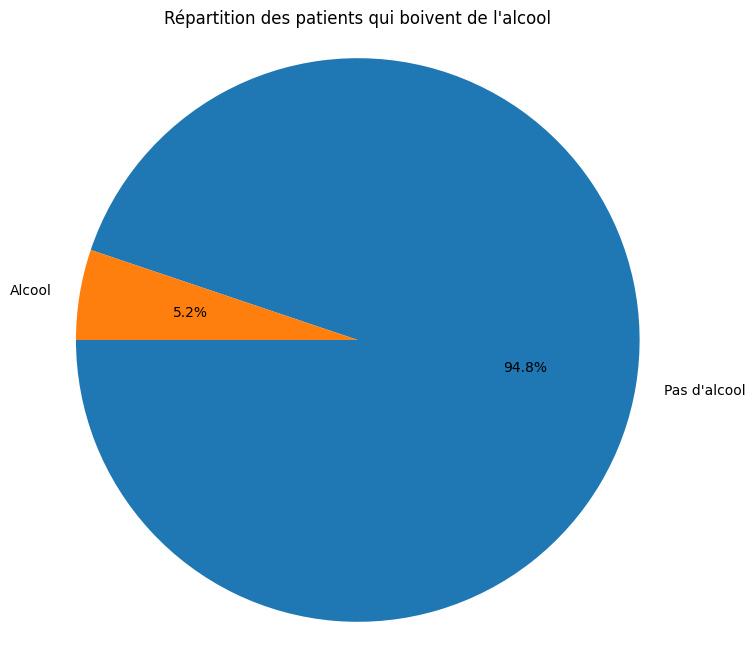

In [278]:
alco_counts = df['alco'].value_counts()

total_patients = alco_counts.sum()
percentages = [count / total_patients * 100 for count in alco_counts]

plt.figure(figsize=(8, 8))
plt.pie(percentages, labels=['Pas d\'alcool', 'Alcool'], autopct='%1.1f%%', startangle=180)
plt.title('Répartition des patients qui boivent de l\'alcool')
plt.axis('equal') 
plt.show()

Colonne 'active'

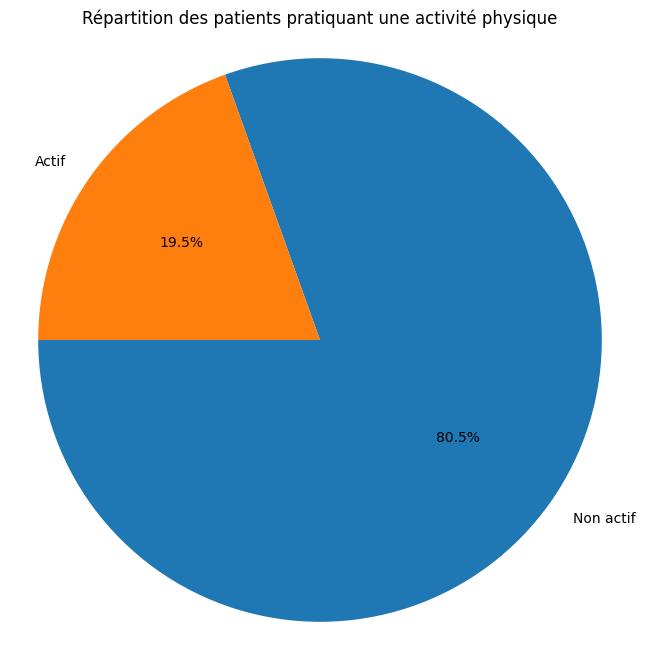

In [280]:
active_counts = df['active'].value_counts()

total_patients = active_counts.sum()
percentages = [count / total_patients * 100 for count in active_counts]

plt.figure(figsize=(8, 8))
plt.pie(percentages, labels=['Non actif', 'Actif'], autopct='%1.1f%%', startangle=180)
plt.title('Répartition des patients pratiquant une activité physique')
plt.axis('equal') 
plt.show()

##### Analyse bivariée

Colonne 'age'

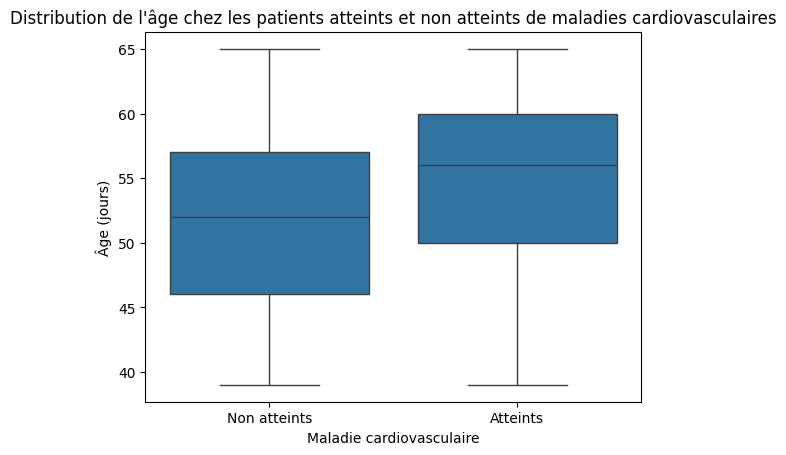

In [262]:
sns.boxplot(x='cardio', y='age', data=df)
plt.xlabel('Maladie cardiovasculaire')
plt.ylabel('Âge (jours)')
plt.title('Distribution de l\'âge chez les patients atteints et non atteints de maladies cardiovasculaires')
plt.xticks([0, 1], ['Non atteints', 'Atteints'])
plt.show()

Colonne 'gender'

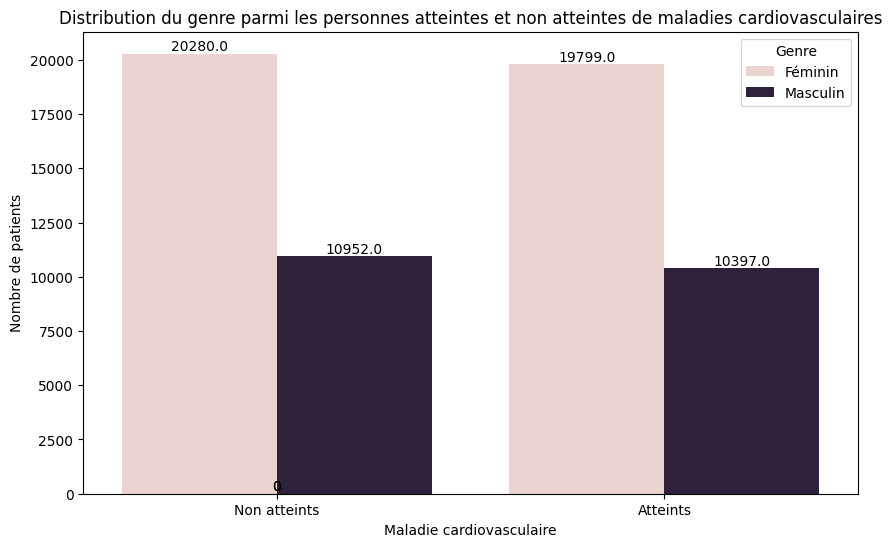

In [281]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='cardio', hue='gender', data=df)
plt.xlabel('Maladie cardiovasculaire')
plt.ylabel('Nombre de patients')
plt.title('Distribution du genre parmi les personnes atteintes et non atteintes de maladies cardiovasculaires')
plt.xticks([0, 1], ['Non atteints', 'Atteints'])
plt.legend(title='Genre', labels=['Féminin', 'Masculin'])

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', color='black')

plt.show()

Colonne 'height'

C:\Users\anton\AppData\Local\Temp\ipykernel_17636\3556186410.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(height_non_cardio, shade=True, color='blue', label='Non atteints')
C:\Users\anton\AppData\Local\Temp\ipykernel_17636\3556186410.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(height_cardio, shade=True, color='red', label='Atteints')


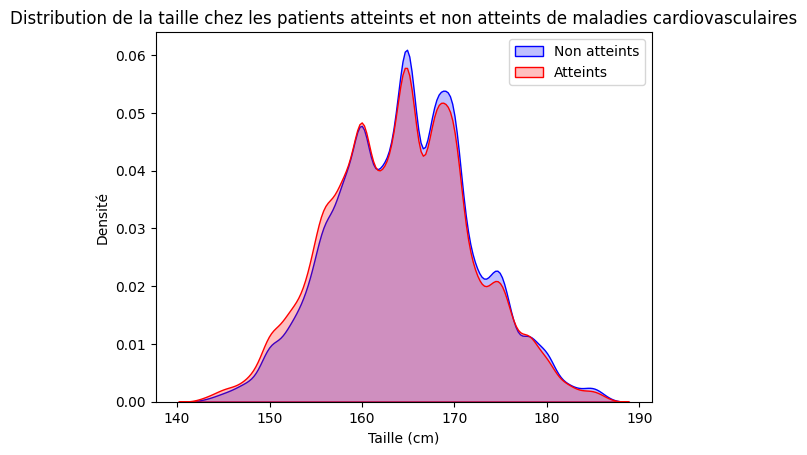

In [263]:
height_non_cardio = df[df['cardio'] == 0]['height']
height_cardio = df[df['cardio'] == 1]['height']
sns.kdeplot(height_non_cardio, shade=True, color='blue', label='Non atteints')
sns.kdeplot(height_cardio, shade=True, color='red', label='Atteints')
plt.xlabel('Taille (cm)')
plt.ylabel('Densité')
plt.title('Distribution de la taille chez les patients atteints et non atteints de maladies cardiovasculaires')
plt.legend()
plt.show()

Colonne 'weight'

C:\Users\anton\AppData\Local\Temp\ipykernel_17636\3271077959.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(weight_non_cardio, shade=True, color='blue', label='Non atteints')
C:\Users\anton\AppData\Local\Temp\ipykernel_17636\3271077959.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(weight_cardio, shade=True, color='red', label='Atteints')


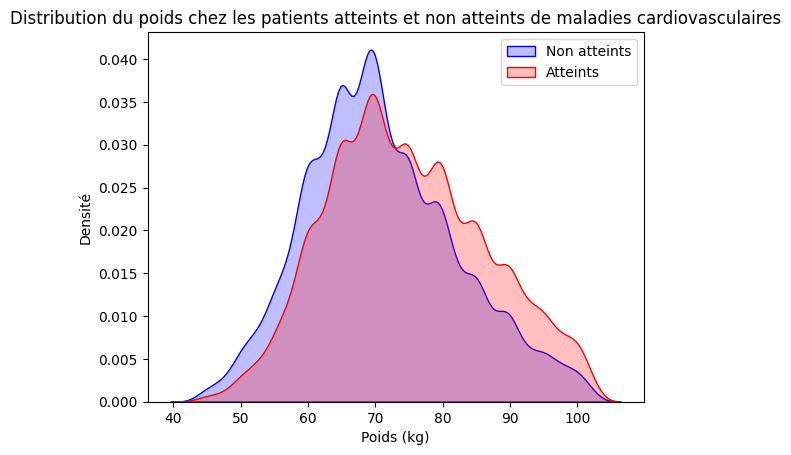

In [264]:
weight_non_cardio = df[df['cardio'] == 0]['weight']
weight_cardio = df[df['cardio'] == 1]['weight']
sns.kdeplot(weight_non_cardio, shade=True, color='blue', label='Non atteints')
sns.kdeplot(weight_cardio, shade=True, color='red', label='Atteints')
plt.xlabel('Poids (kg)')
plt.ylabel('Densité')
plt.title('Distribution du poids chez les patients atteints et non atteints de maladies cardiovasculaires')
plt.legend()
plt.show()

Colonne 'ap_hi'

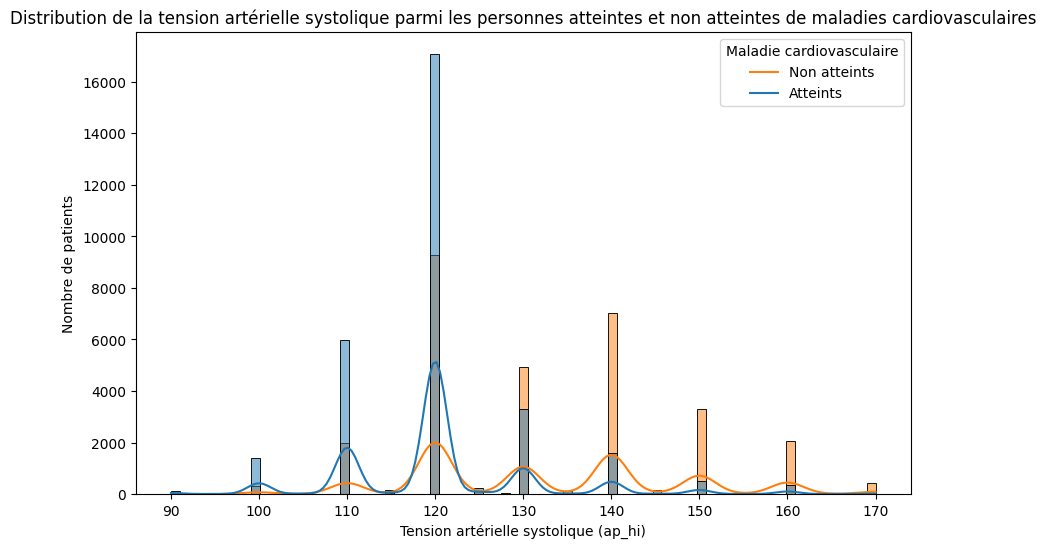

In [282]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='ap_hi', hue='cardio', kde=True)
plt.xlabel('Tension artérielle systolique (ap_hi)')
plt.ylabel('Nombre de patients')
plt.title('Distribution de la tension artérielle systolique parmi les personnes atteintes et non atteintes de maladies cardiovasculaires')
plt.legend(title='Maladie cardiovasculaire', labels=['Non atteints', 'Atteints'])
plt.show()

Colonne 'ap_lo'

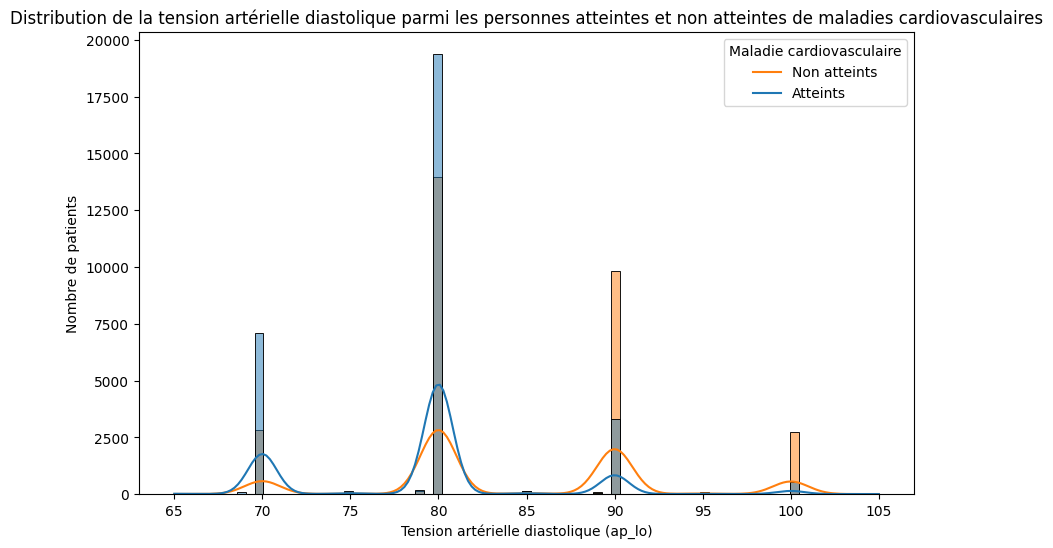

In [267]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='ap_lo', hue='cardio', kde=True)
plt.xlabel('Tension artérielle diastolique (ap_lo)')
plt.ylabel('Nombre de patients')
plt.title('Distribution de la tension artérielle diastolique parmi les personnes atteintes et non atteintes de maladies cardiovasculaires')
plt.legend(title='Maladie cardiovasculaire', labels=['Non atteints', 'Atteints'])
plt.show()

Colonne 'cholesterol'

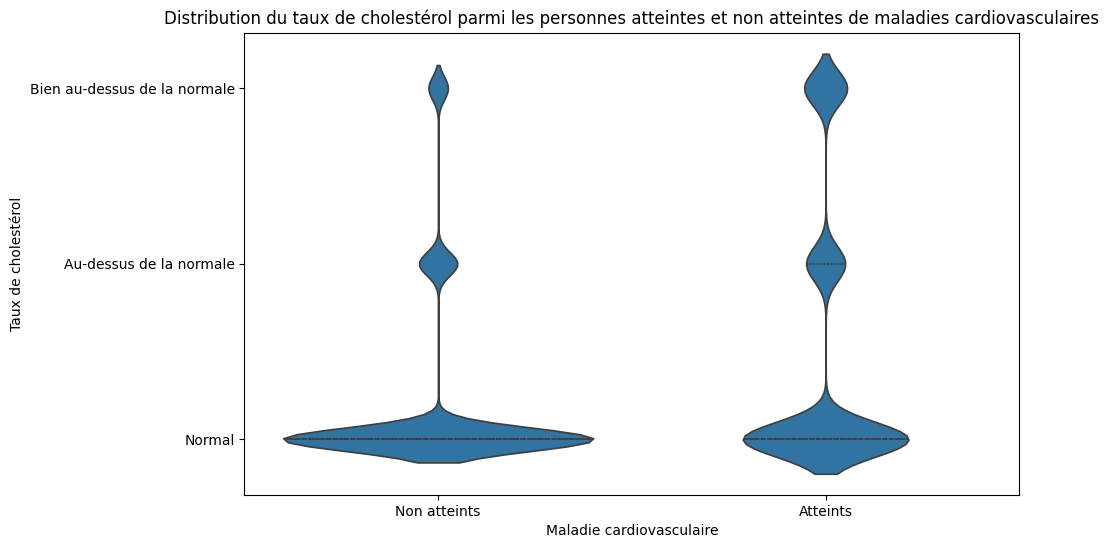

In [268]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='cardio', y='cholesterol', data=df, inner='quartile')
plt.xlabel('Maladie cardiovasculaire')
plt.ylabel('Taux de cholestérol')
plt.title('Distribution du taux de cholestérol parmi les personnes atteintes et non atteintes de maladies cardiovasculaires')
plt.xticks([0, 1], ['Non atteints', 'Atteints'])
plt.yticks([1, 2, 3], ['Normal', 'Au-dessus de la normale', 'Bien au-dessus de la normale'])
plt.show()

Colonne 'gluc'

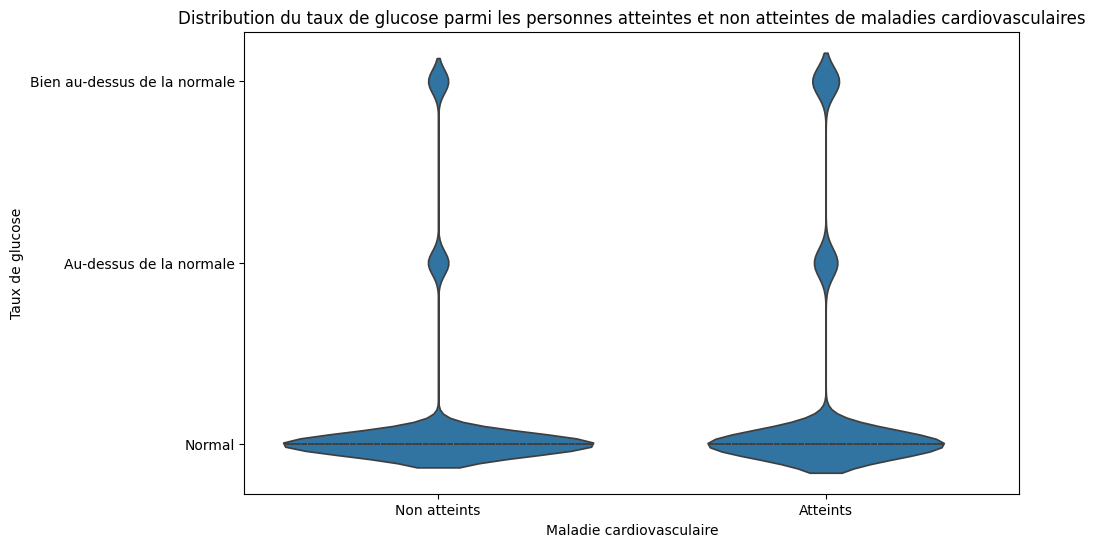

In [269]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='cardio', y='gluc', data=df, inner='quartile')
plt.xlabel('Maladie cardiovasculaire')
plt.ylabel('Taux de glucose')
plt.title('Distribution du taux de glucose parmi les personnes atteintes et non atteintes de maladies cardiovasculaires')
plt.xticks([0, 1], ['Non atteints', 'Atteints'])
plt.yticks([1, 2, 3], ['Normal', 'Au-dessus de la normale', 'Bien au-dessus de la normale'])
plt.show()

Colonne 'smoke'

<Figure size 1000x600 with 0 Axes>

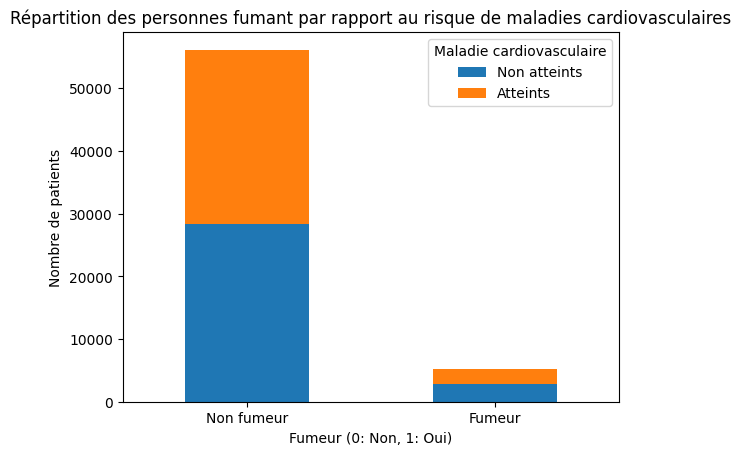

In [291]:
smoking_counts = df.groupby(['smoke', 'cardio']).size().unstack()

plt.figure(figsize=(10, 6))
smoking_counts.plot(kind='bar', stacked=True)

plt.title('Répartition des personnes fumant par rapport au risque de maladies cardiovasculaires')
plt.xlabel('Fumeur (0: Non, 1: Oui)')
plt.ylabel('Nombre de patients')
plt.xticks([0, 1], ['Non fumeur', 'Fumeur'], rotation=0)
plt.legend(title='Maladie cardiovasculaire', labels=['Non atteints', 'Atteints'])
plt.show()

Colonne 'alco'

<Figure size 1000x600 with 0 Axes>

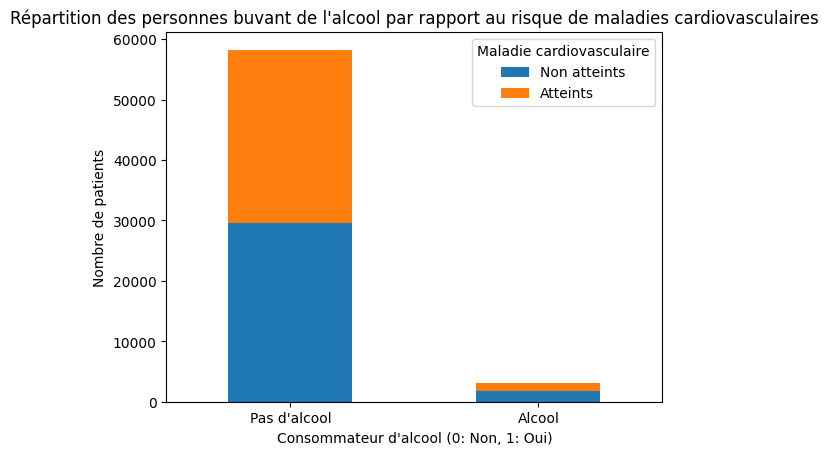

In [293]:
alco_counts = df.groupby(['alco', 'cardio']).size().unstack()

plt.figure(figsize=(10, 6))
alco_counts.plot(kind='bar', stacked=True)

plt.title('Répartition des personnes buvant de l\'alcool par rapport au risque de maladies cardiovasculaires')
plt.xlabel('Consommateur d\'alcool (0: Non, 1: Oui)')
plt.ylabel('Nombre de patients')
plt.xticks([0, 1], ['Pas d\'alcool', 'Alcool'], rotation=0)
plt.legend(title='Maladie cardiovasculaire', labels=['Non atteints', 'Atteints'])
plt.show()

Colonne 'active'

<Figure size 1000x600 with 0 Axes>

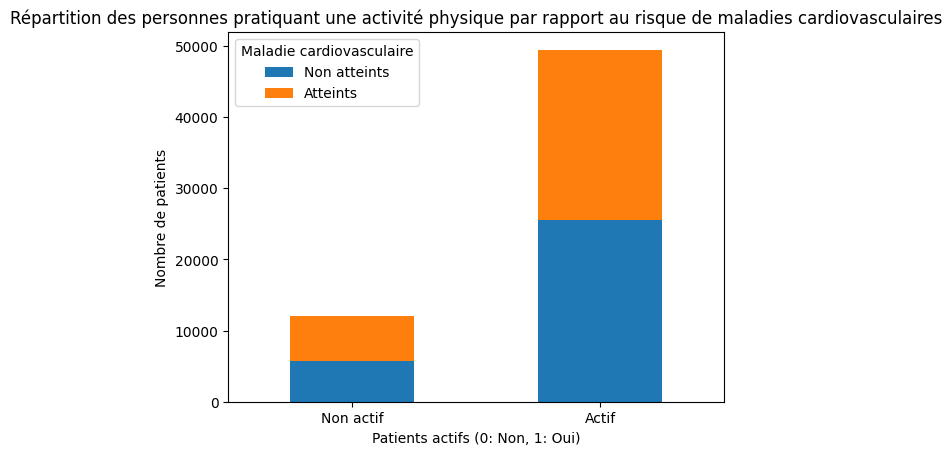

In [296]:
active_counts = df.groupby(['active', 'cardio']).size().unstack()

plt.figure(figsize=(10, 6))
active_counts.plot(kind='bar', stacked=True)

plt.title('Répartition des personnes pratiquant une activité physique par rapport au risque de maladies cardiovasculaires')
plt.xlabel('Patients actifs (0: Non, 1: Oui)')
plt.ylabel('Nombre de patients')
plt.xticks([0, 1], ['Non actif', 'Actif'], rotation=0)
plt.legend(title='Maladie cardiovasculaire', labels=['Non atteints', 'Atteints'])
plt.show()

##### Analyse multivariée

c:\Users\anton\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


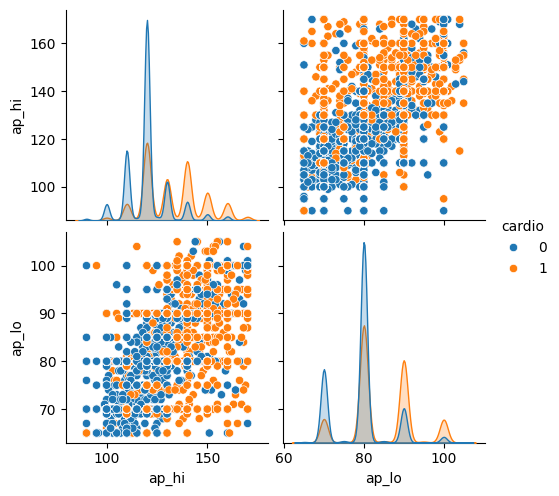

In [270]:
sns.pairplot(df, vars=['ap_hi', 'ap_lo'], hue='cardio')
plt.show()